<a href="https://colab.research.google.com/github/isikus/qualification-project/blob/master/notebooks/2.%20Preparing%20train,%20validation%20and%20test%20sets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing train, validation and test sets
In this notebook we merge the resulting corpora, drop the undesired parts, preprocess the texts for T5 model and upload them to Google Cloud Storage where we store our model

**Please note the following:**
1. This notebook is adapted for Google Colab. Your procedure of installing `jamspell` may be different.
2. It is assumed that you have the pickles from [this notebook](https://github.com/isikus/qualification-project/blob/master/notebooks/1.%20Converting%20datasets%20to%20parallel%20corpora.ipynb) in your starting folder. If you have them uploaded to your Google Drive, please uncomment the correspondent cells.
3. The final block of code here uploads the resulting datasets to Google Cloud Storage in order to train the model. At the moment, we do not know alternative procedures to train the T5 model efficiently.

## Imports and necessary dependencies

In [0]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [0]:
!pip install transformers

     |████████████████████████████████| 665kB 2.6MB/s 
     |████████████████████████████████| 1.1MB 8.6MB/s 
     |████████████████████████████████| 890kB 19.3MB/s 
     |████████████████████████████████| 3.8MB 23.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=f9f729f252295bc4328751b56a266448e8acd68d0327dbd98f821ee0e24bd776
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from datetime import datetime
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

from tqdm.auto import tqdm

tqdm.pandas()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
from contextlib import contextmanager,redirect_stderr,redirect_stdout
from os import devnull

@contextmanager
def suppress_stdout_stderr():
    """A context manager that redirects stdout and stderr to devnull"""
    with open(devnull, 'w') as fnull:
        with redirect_stderr(fnull) as err, redirect_stdout(fnull) as out:
            yield (err, out)

## Preparing the workspace

In [0]:
# !cp /content/gdrive/My\ Drive/*.pickle .

In [0]:
%%time

df_dict = {}

for filef in os.listdir("."):
  base, ext = os.path.splitext(filef)
  if ext == ".pickle":
    exec('%s = pd.read_pickle("%s")' % (base, filef))
    if base == "efcamdat_df":
      efcamdat_df.columns = ["id"] + list(efcamdat_df.columns)[1:]
      efcamdat_df = efcamdat_df.drop([343497, 690550, 710090])  # these entries were causing trouble 
    exec('df_dict["%s"] = %s' % (base, base))

dfs = list(df_dict.keys())

CPU times: user 749 ms, sys: 2.27 s, total: 3.02 s
Wall time: 3.04 s


In [0]:
tokenizer = T5Tokenizer.from_pretrained('t5-3b')

In [0]:
def count_tokens(intext):
  with suppress_stdout_stderr():
    return len(tokenizer.encode(intext))

As we expect some underannotated data in our datasets, we do not want to target the model for some texts which are in fact not corrected. This is why here we perform some additional manual cleanup to our datasets. Next we will declare a function to count the number of corrections relative to the number of tokens in the uncorrected text, as the absolute count of edits is not so descriptive given that the properly annotated longer texts are expected to have more edits, which is in fact a meaningless increase. We use the tokenizer that our model will apply for the sake of consistency.

In [0]:
%%time

for df_name in dfs:
  time_then = datetime.now()
  df = df_dict[df_name]
  df["tokens_num"] = df["orig_text"].progress_apply(count_tokens)
  df["corr_quantity"] = df["corrections_num"] / df["tokens_num"]
  time_now = datetime.now()
  print("Processed", df_name, "in", time_now - time_then)


Processed fce_dev_df in 0:00:00.181674



Processed wi_locness_dev_df in 0:00:00.322045



Processed fuse_1025200 in 0:00:00.050732



Processed efcamdat_df in 0:04:19.803011



Processed wi_locness_train_df in 0:00:02.036500



Processed spc_1076500 in 0:00:00.048037



Processed fuse_1050000 in 0:00:00.061033



Processed realec_df_train in 0:00:11.523679



Processed nucle_df in 0:00:03.451226



Processed fce_train_df in 0:00:01.455566



Processed fce_test_df in 0:00:00.176456



Processed realec_df_gold in 0:00:00.118879



Processed icnale_df in 0:00:00.545613
CPU times: user 4min 31s, sys: 9.55 s, total: 4min 40s
Wall time: 4min 39s


In [0]:
import matplotlib.pyplot as plt

## Describing FCE

FCE provides three subsets: `train`, `dev` and `test`, which we will use for validation, testing and training (scoring) accordingly. We expect fairly clean results from FCE dataset, with corrections for pretty much every text, so here we will just set up our dataset analysis procedure and see how the things should look like for a model dataset.

In [0]:
print("Dataset size for FCE dev:", len(fce_dev_df))
print("Dataset size for FCE train:", len(fce_train_df))
print("Dataset size for FCE test:", len(fce_test_df))

Dataset size for FCE dev: 159
Dataset size for FCE train: 2116
Dataset size for FCE test: 194


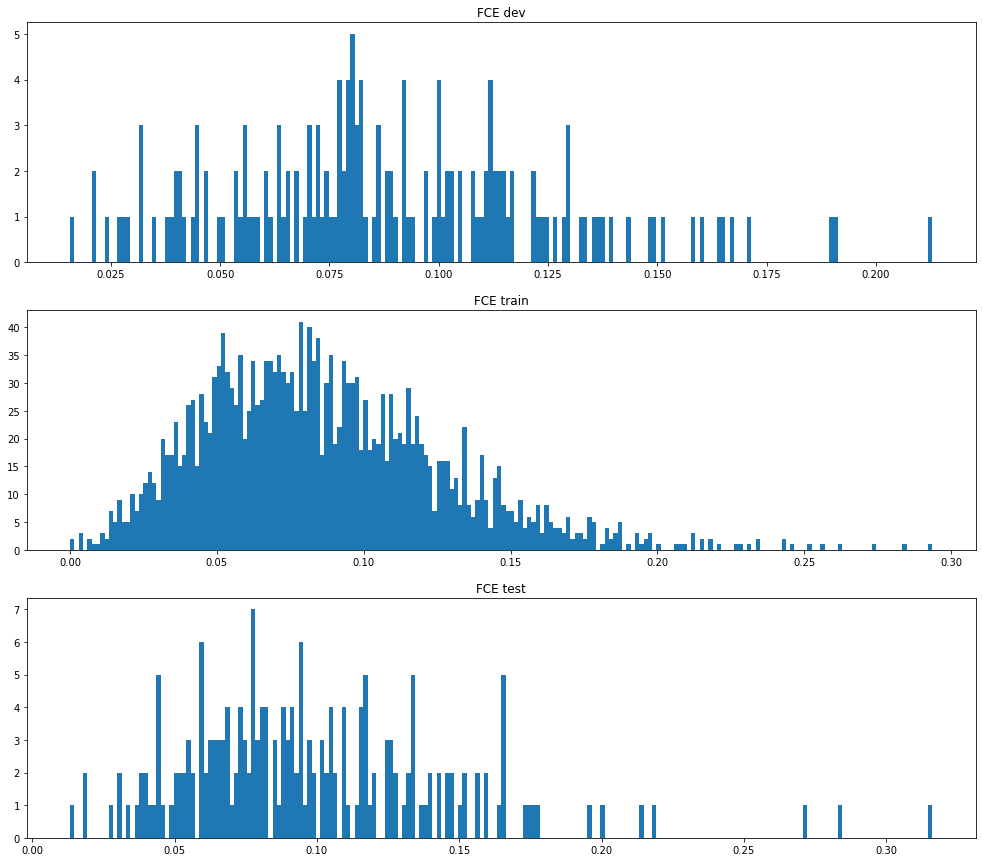

In [0]:
fig, ax = plt.subplots(3, 1, figsize=(17, 15))

ax[0].set_title("FCE dev")
n0, bins0, patches0 = ax[0].hist(fce_dev_df["corr_quantity"], bins=200)

ax[1].set_title("FCE train")
n1, bins1, patches1 = ax[1].hist(fce_train_df["corr_quantity"], bins=200)

ax[2].set_title("FCE test")
n2, bins2, patches2 = ax[2].hist(fce_test_df["corr_quantity"], bins=200)

So the quantities are distributed normally with a long right tail, produced presumably by some short text full of errors. The distribution is centered around 0.07, with the text having zero changes are pretty much rare outliers.

## Describing W+I & LOCNESS

W+I LOCNESS is another model dataset which is is considered standard in grammatical error correction. Here, there is no `test` subset, as it is instead distributed in the form of raw text, with the corrections and metrices counted within internal contest evaluation system. Another difference is that the `dev` set contains some native texts, which we don't want to break too much an again will be using in validation.

In [0]:
print("Dataset size for W+I & LOCNESS dev:", len(wi_locness_dev_df))
print("Dataset size for W+I & LOCNESS train:", len(wi_locness_train_df))

Dataset size for W+I & LOCNESS dev: 350
Dataset size for W+I & LOCNESS train: 3000


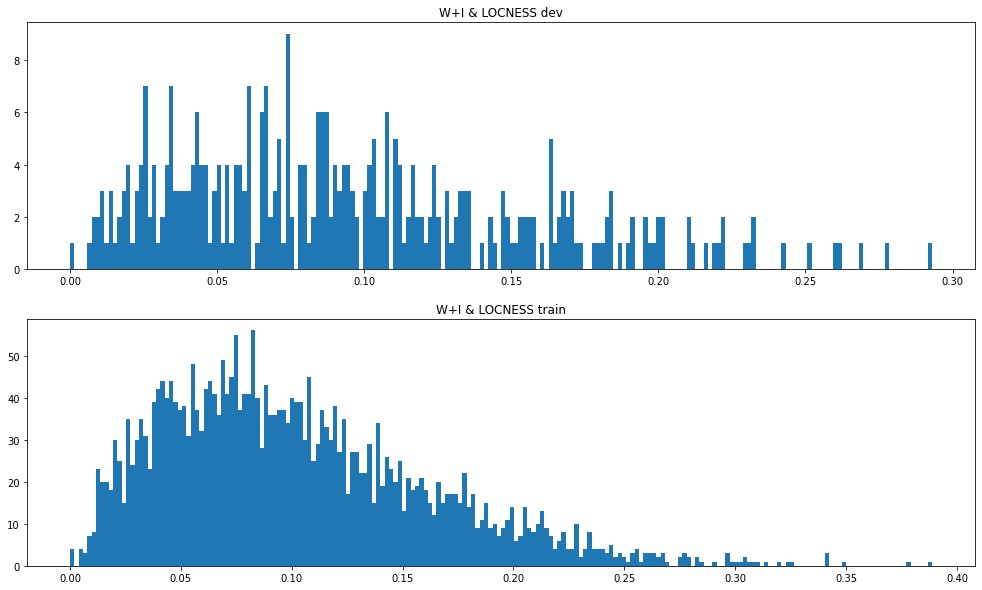

In [0]:
fig, ax = plt.subplots(2, 1, figsize=(17, 10))

ax[0].set_title("W+I & LOCNESS dev")
n0, bins0, patches0 = ax[0].hist(wi_locness_dev_df["corr_quantity"], bins=200)

ax[1].set_title("W+I & LOCNESS train")
n1, bins1, patches1 = ax[1].hist(wi_locness_train_df["corr_quantity"], bins=200)

Here we have pretty much the same distribution centered around 0.07, although with a larger right tail.

## Describing NUCLE

The NUCLE dataset is also widely used in GEC tasks, which we consider to be well-annotated and not in need for any cleanup. Nevertheless, NUCLE is less modelling for us, as it is somewhat further from IELTS essay format we are pursuing.

In [0]:
print("Dataset size for NUCLE:", len(nucle_df))

Dataset size for NUCLE: 1397


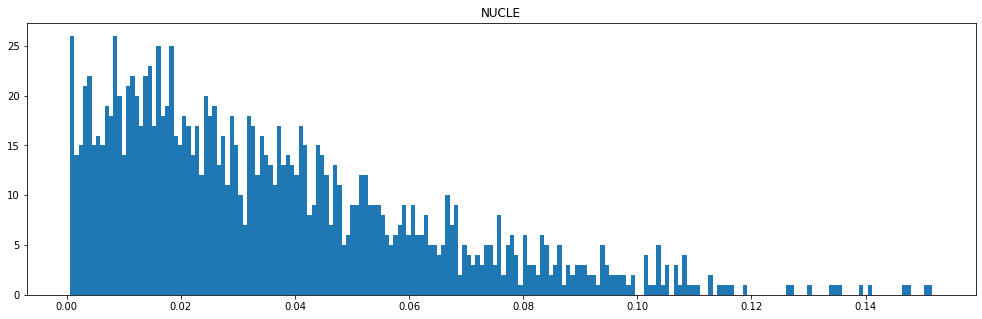

In [0]:
fig, ax = plt.subplots(figsize=(17, 5))

ax.set_title("NUCLE")
n0, bins0, patches0 = ax.hist(nucle_df["corr_quantity"], bins=200)

Pretty unexpectedly, we observe a pretty significant positive skew, with the mode being around 0.01. This surely means that we have a differently structured data in NUCLE. Just to be sure, we will cut off anything with quantity 

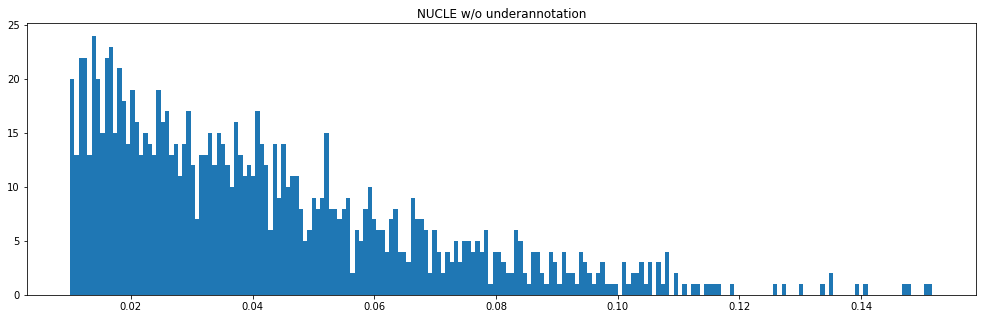

In [0]:
nucle_wo_zeroes = [q for q in list(nucle_df["corr_quantity"]) if q >= 0.01]

fig, ax = plt.subplots(figsize=(17, 5))

ax.set_title("NUCLE w/o underannotation")
n0, bins0, patches0 = ax.hist(nucle_wo_zeroes, bins=200)

In [0]:
len(nucle_wo_zeroes)

1165

## Describing ICNALE

ICNALE is a farly well-annotated dataset consisting of Japanese learners' essays on a number of general topics. While the distribution here will be fairly similar to what we have seen before, the main downside for ICNALE here is that it is pretty small compared to the other datasets.

In [0]:
print("Dataset size for ICNALE:", len(icnale_df))

Dataset size for ICNALE: 639


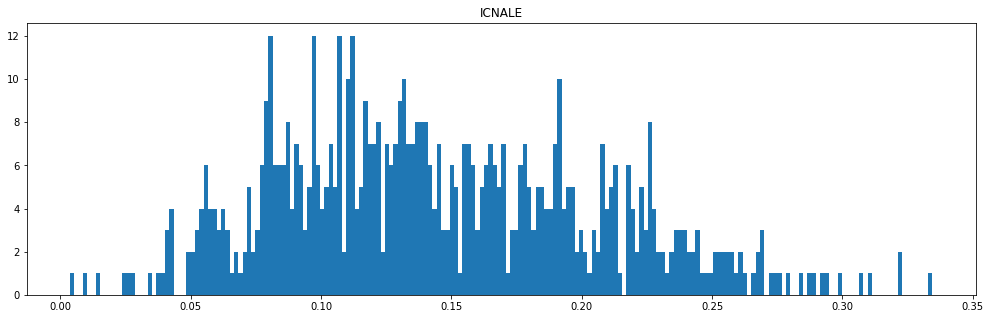

In [0]:
fig, ax = plt.subplots(figsize=(17, 5))

ax.set_title("ICNALE")
n0, bins0, patches0 = ax.hist(icnale_df["corr_quantity"], bins=200)

## Describing REALEC

In [0]:
print("Dataset size for REALEC golden set:", len(realec_df_gold))
print("Dataset size for REALEC train set:", len(realec_df_train))

Dataset size for REALEC golden set: 64
Dataset size for REALEC train set: 13218


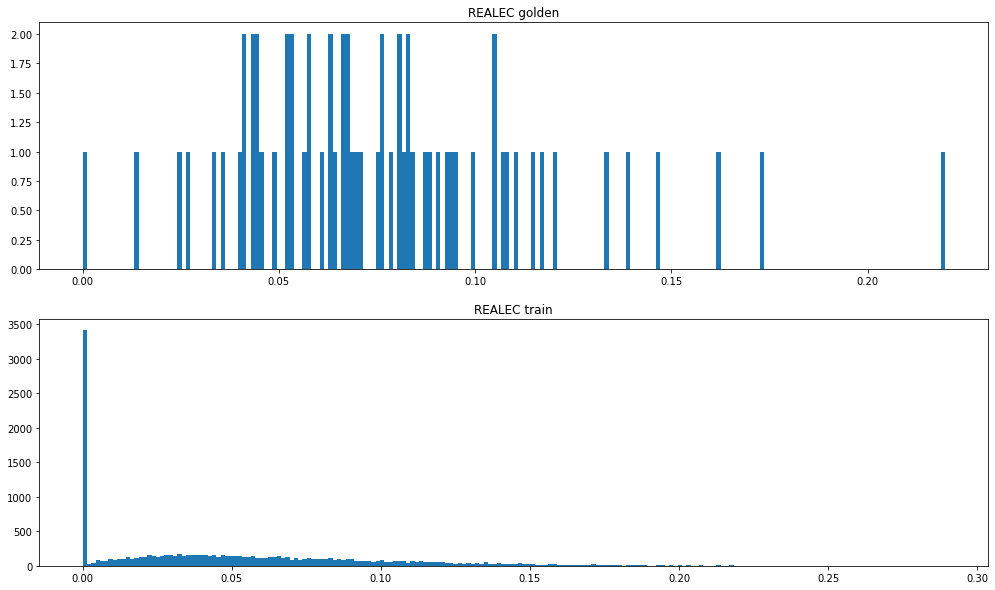

In [0]:
fig, ax = plt.subplots(2, 1, figsize=(17, 10))

ax[0].set_title("REALEC golden")
n0, bins0, patches0 = ax[0].hist(realec_df_gold["corr_quantity"], bins=200)

ax[1].set_title("REALEC train")
n1, bins1, patches1 = ax[1].hist(realec_df_train["corr_quantity"], bins=200)

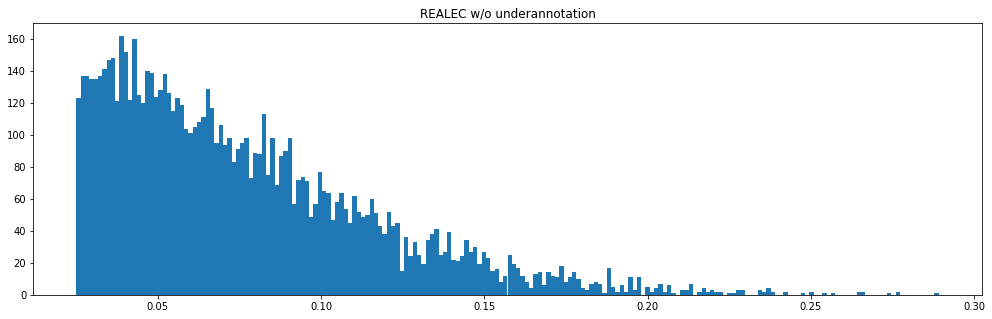

In [0]:
realec_wo_zeroes = [q for q in list(realec_df_train["corr_quantity"]) if q >= 0.025]

fig, ax = plt.subplots(figsize=(17, 5))

ax.set_title("REALEC w/o underannotation")
n0, bins0, patches0 = ax.hist(realec_wo_zeroes, bins=200)

In [0]:
len(realec_wo_zeroes)

8194

## Describing EFCamDat

Lastly, there is EFCamDat, which will provide the main bulk of training data for us. 

In [0]:
print("Dataset size for EFCamDat:", len(efcamdat_df))

Dataset size for EFCamDat: 965120


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


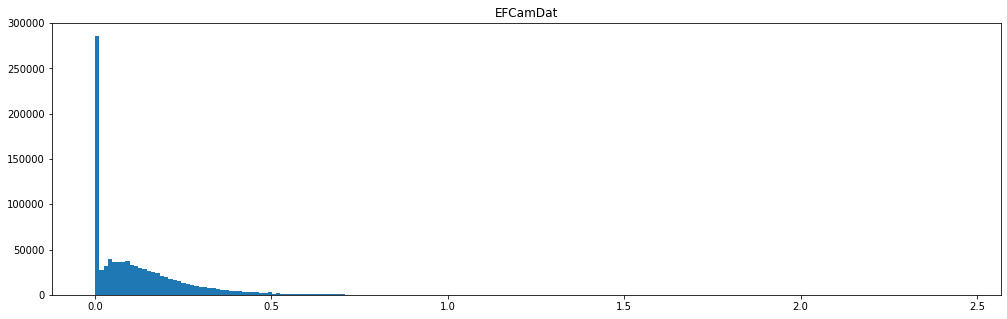

In [0]:
fig, ax = plt.subplots(figsize=(17, 5))

ax.set_title("EFCamDat")
n0, bins0, patches0 = ax.hist(efcamdat_df["corr_quantity"], bins=200)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


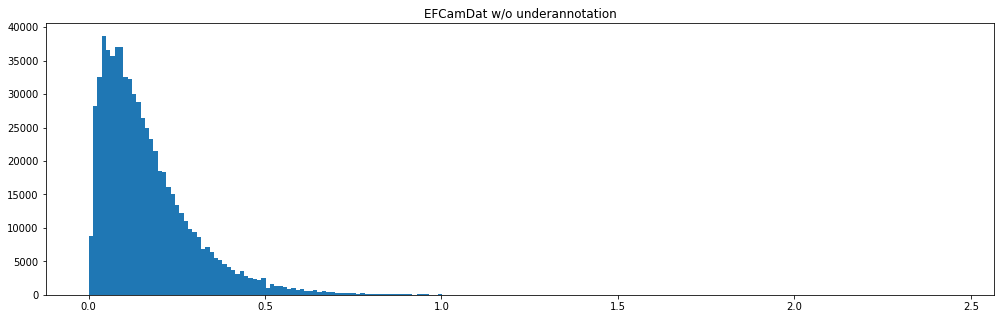

In [0]:
efcamdat_wo_zeroes = [q for q in list(efcamdat_df["corr_quantity"]) if q != 0.0]

fig, ax = plt.subplots(figsize=(17, 5))

ax.set_title("EFCamDat w/o underannotation")
n0, bins0, patches0 = ax.hist(efcamdat_wo_zeroes, bins=200)

In [0]:
len(efcamdat_wo_zeroes)

687265

## Removing underannotated data

As stated earlier, we encountered some underannotated entries in our datasets. Here, we drop texts with *q* ≤ 0.025 in REALEC, *q* = 0 in EFCAMDAT and with *q* ≤ 0.01 from NUCLE

In [0]:
lb = len(nucle_df)
nucle_df = nucle_df.loc[nucle_df["corr_quantity"] >= 0.01]
la = len(nucle_df)
print("Lost", lb - la, "entries in NUCLE after underannotation cleaning")

lb = len(realec_df_train)
realec_df_train = realec_df_train.loc[realec_df_train["corr_quantity"] >= 0.025]
la = len(realec_df_train)
print("Lost", lb - la, "entries in REALEC-train after underannotation cleaning")

lb = len(efcamdat_df)
efcamdat_df = efcamdat_df.loc[efcamdat_df["corr_quantity"] != 0.0]
la = len(efcamdat_df)
print("Lost", lb - la, "entries in EFCamDat after underannotation cleaning")

Lost 232 entries in NUCLE after underannotation cleaning
Lost 5024 entries in REALEC-train after underannotation cleaning
Lost 277855 entries in EFCamDat after underannotation cleaning


## Refactor and recombine the datasets with appliance to the maximum input sequence length

The model has a maximum limit for input sequence length of 512, and we have a number of entries that exceed this limit. The bad news is that we have parallel texts and we want to split them accordingly; the somewhat better news is that they mostly have paragraphs and we can split the texts by them. For precaution sake, we will set the limit to 510, as we will still have to declare the task in input data later on. So we will have to discard the entries where the number of paragraphs between original and corrected texts does not match; for the rest we will assume that the paragraphs are aligned correctly and split the texts by them. We will not split the entries which are within the limits of 510 tokens.

In [0]:
def check_paragraphs(orig_text, corr_text, tokenizer, max_tokens):
  orig_parrs = [p + "\n" for p in re.split(r"\n+", orig_text) if p]
  corr_parrs = [p + "\n" for p in re.split(r"\n+", corr_text) if p]

  if len(orig_parrs) != len(corr_parrs):
    return False
  
  with suppress_stdout_stderr():
    orig_ntokens = [len(tokenizer.encode(p)) for p in orig_parrs]
    corr_ntokens = [len(tokenizer.encode(p)) for p in corr_parrs]

  if any(l > max_tokens for l in orig_ntokens + corr_ntokens):
    return None
  
  curlen = [0, 0]
  orig = []
  corr = []
  cur_or = orig_parrs[0]
  cur_corr = corr_parrs[0]

  for _i, parrs in enumerate(zip(orig_ntokens[1:], corr_ntokens[1:])):
    i = _i + 1
    orig_len = orig_ntokens[i]
    corr_len = corr_ntokens[i]
    if (curlen[0] + orig_len > max_tokens) or (curlen[1] + corr_len > max_tokens):
      orig.append(cur_or[:-1])
      corr.append(cur_corr[:-1])
      cur_or = orig_parrs[i]
      cur_corr = orig_parrs[i]
      curlen = [0, 0]
    else:
      cur_or += orig_parrs[i]
      cur_corr += corr_parrs[i]
      curlen[0] += orig_len
      curlen[1] += corr_len
  
  orig.append(cur_or[:-1])
  corr.append(cur_corr[:-1])

  return zip(orig, corr)

In [0]:
def refactor_df(df, df_name, tokenizer):
  MAX_TOKENS = 510

  paragraphs_mismatch = 0
  exceeded_length = 0

  cols = tuple(df.columns)
  df_dict = {c: [] for c in ["id", "orig_text", "corr_text"]}
  for row in tqdm(list(zip(df["id"], df["orig_text"], df["corr_text"], df["tokens_num"]))):
    fid = row[0]
    orig_text = row[1].strip()
    corr_text = row[2].strip()
    orig_tokens = row[3]
    corr_tokens = count_tokens(corr_text)
    max_token_count = max(orig_tokens, corr_tokens)
    if row[-1] <= MAX_TOKENS:
      df_dict["id"].append(df_name.replace("_df", "") + "/" + str(fid))
      df_dict["orig_text"].append(re.sub(r"\n+", r"\n", orig_text))
      df_dict["corr_text"].append(re.sub(r"\n+", r"\n", corr_text))
    else:
      parr_iter = check_paragraphs(orig_text, corr_text, tokenizer, MAX_TOKENS)
      if parr_iter is False:
        paragraphs_mismatch += 1
        continue
      if parr_iter is None:
        exceeded_length += 1
        continue
      for i, z in enumerate(parr_iter):
        df_dict["id"].append(df_name.replace("_df", "") + "/" + str(fid) + "-" + str(i+1))
        df_dict["orig_text"].append(z[0])
        df_dict["corr_text"].append(z[1])
    
  new_df = pd.DataFrame(df_dict)
  new_df = new_df[["id", "orig_text", "corr_text"]]

  return new_df, paragraphs_mismatch, exceeded_length

In [0]:
%%time

for df_name in dfs:
  time_then = datetime.now()
  df = df_dict[df_name]
  new_df, paragraphs_mismatch, exceeded_length = refactor_df(df, df_name, tokenizer)
  exec("%s = new_df" % df_name)
  exec('df_dict["%s"] = %s' % (df_name, df_name))
  time_now = datetime.now()
  print("Lost due to paragraphs mismatch in", df_name+":", paragraphs_mismatch)
  print("Lost due to exceeding max sequence length in", df_name+":", exceeded_length)
  print("Processed", df_name, "in", time_now - time_then)


Lost due to paragraphs mismatch in fce_dev_df: 0
Lost due to exceeding max sequence length in fce_dev_df: 0
Processed fce_dev_df in 0:00:00.161074



Lost due to paragraphs mismatch in wi_locness_dev_df: 1
Lost due to exceeding max sequence length in wi_locness_dev_df: 0
Processed wi_locness_dev_df in 0:00:00.494959



Lost due to paragraphs mismatch in fuse_1025200: 0
Lost due to exceeding max sequence length in fuse_1025200: 0
Processed fuse_1025200 in 0:00:00.055100



Lost due to paragraphs mismatch in efcamdat_df: 2
Lost due to exceeding max sequence length in efcamdat_df: 134
Processed efcamdat_df in 0:04:51.828176



Lost due to paragraphs mismatch in wi_locness_train_df: 3
Lost due to exceeding max sequence length in wi_locness_train_df: 3
Processed wi_locness_train_df in 0:00:02.884395



Lost due to paragraphs mismatch in spc_1076500: 0
Lost due to exceeding max sequence length in spc_1076500: 0
Processed spc_1076500 in 0:00:00.053924



Lost due to paragraphs mismatch in fuse_1050000: 0
Lost due to exceeding max sequence length in fuse_1050000: 0
Processed fuse_1050000 in 0:00:00.057063



Lost due to paragraphs mismatch in realec_df_train: 0
Lost due to exceeding max sequence length in realec_df_train: 68
Processed realec_df_train in 0:00:15.677571



Lost due to paragraphs mismatch in nucle_df: 13
Lost due to exceeding max sequence length in nucle_df: 78
Processed nucle_df in 0:00:10.512338



Lost due to paragraphs mismatch in fce_train_df: 0
Lost due to exceeding max sequence length in fce_train_df: 0
Processed fce_train_df in 0:00:01.622967



Lost due to paragraphs mismatch in fce_test_df: 0
Lost due to exceeding max sequence length in fce_test_df: 0
Processed fce_test_df in 0:00:00.190471



Lost due to paragraphs mismatch in realec_df_gold: 0
Lost due to exceeding max sequence length in realec_df_gold: 0
Processed realec_df_gold in 0:00:00.117583



Lost due to paragraphs mismatch in icnale_df: 0
Lost due to exceeding max sequence length in icnale_df: 0
Processed icnale_df in 0:00:00.599739
CPU times: user 5min 13s, sys: 12.7 s, total: 5min 25s
Wall time: 5min 24s


Let's check paragraphs alignment on some datasets:

In [0]:
realec_df_train.sample(12)

,id,orig_text,corr_text
9256,realec_train/exam/exam2017_old/EGe_100-199/EGe...,The graphs below show the population size's ch...,The graphs show the population size changes in...
8439,realec_train/exam/exam2017/VSa_1-138/VSa_25_2.txt,"In centuary of modern technologies, which can ...","In the century of modern technologies, which c..."
2349,realec_train/Exam_practice/Pedagogish_essays/e...,"So, all in all, throughout the book progressio...","So, all in all, throughout the book progressio..."
4192,realec_train/exam/Exam2014/MTsy_32_1.txt,The given pie charts show the information abou...,The given pie charts show the information on p...
9026,realec_train/exam/exam2017_old/EGe_1-99/EGe_35...,It is undoubtedly that With modern pace of lif...,It is undoubtedly that With modern pace of lif...
2775,realec_train/MAGOLEGO/2018/Student_14_MT.txt,The motion for today is “A few West Coast tech...,"The motion for today is ""A few West Coast tech..."
5485,realec_train/exam/Exam2016/MTsy_56_2.txt,"Undoubtedly, modern globalisation significantl...","Undoubtedly, modern globalisation significantl..."
7169,realec_train/exam/exam2017/EGe_1-99/EGe_58_2.txt,Nowadays the population can not imagine our Wo...,Nowadays the population can not imagine our Wo...
8143,realec_train/exam/exam2017/OBy_100-200/OBy_105...,The graph portrays changes in the unemployment...,The graph portrays changes in the unemployment...
9224,realec_train/exam/exam2017_old/EGe_100-199/EGe...,Nowadays social networks are becoming more pop...,Nowadays social networks are becoming more pop...


In [0]:
efcamdat_df.sample(12)

,id,orig_text,corr_text
634280,efcamdat/634357,"Hi Bobby, I really hope you feel less blue whe...","Hi, Bobby. I really hope you feel less blue wh..."
682483,efcamdat/682563,I always go to first floor. The shoe store are...,I always go to the first floor. The shoe store...
264413,efcamdat/264452,"To play at Frisbee Bowling, fill a little wate...","To play Frisbee bowling, fill a little water i..."
711386,efcamdat/711469,Chihuahua is a really big city in Mexico. Has ...,Chihuahua is a really big city in Mexico. Has ...
636065,efcamdat/636143,"Career plan \n1 - Actually, I am in charge of ...","Career plan \n1 - Actually, I am in charge of ..."
25843,efcamdat/25849,"Dear Sir or Madam,\nI am writing to request a ...","Dear Sir or Madam,\nI am writing to request a ..."
68257,efcamdat/68275,Many tvs shows tv programs with sex and violen...,Many TV shows with sex and violence. Evening s...
105559,efcamdat/105583,The Kura-Sushi is my favorite restaurant. They...,The Kura-Sushi is my favorite restaurant. They...
763080,efcamdat/763167,There was a murder in my city eight years ago....,There was a murder in my city eight years ago....
594821,efcamdat/594892,Lili invites you to his birthday paty. I'm be ...,Lili invites you to his birthday party. I'm be...


## Preparing data for T5 

As we are looking to apply hyperparameter search and could wish for more training data, we will not direct much data for testing, aside from official test subsets, like FCE test, which will not be used in model training or validation. We may still draw some texts from the underannotated sections we previously omitted. We do want, however, to have a good validation subset, although we do not want for it to be dominated by EFCamDat subset. So we will direct both the dev subsets from FCE and W+I & LOCNESS to validation, as well as golden subset from REALEC, and furthermore add 8% of REALEC training data and 10% from general sets for both NUCLE and ICNALE.

As for scoring, each configuration will be scored on the combination of FCE-dev, WI-LOCNESS-dev and REALEC-gold subsets.

First, we shuffle all the datasets with a reproducible seed:

In [0]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  return seed

SEED = set_seed(42)

In [0]:
for df_name in dfs:
  df = df_dict[df_name]
  df = df.sample(frac=1, random_state=SEED)
  exec("%s = df" % df_name)
  exec('df_dict["%s"] = %s' % (df_name, df_name))

Then, we construct the datasets needed to train the `fuse` model:

In [0]:
correct_val_df = pd.concat([fce_dev_df, \
                            wi_locness_dev_df, \
                            realec_df_gold, \
                            realec_df_train[:int(len(realec_df_train) * 0.08)], \
                            nucle_df[:int(len(nucle_df) * 0.1)], \
                            icnale_df[:int(len(icnale_df) * 0.1)]], ignore_index=True)

len_so_far = len(correct_val_df)

In [0]:
correct_val_df = pd.concat([correct_val_df, correct_val_df], ignore_index=True)  # doubling the size to double the effect of non-efcamdat datasets
len_so_far = len(correct_val_df)

In [0]:
correct_val_df_2 = pd.concat([correct_val_df,
                            efcamdat_df[:len_so_far]], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

len(correct_val_df_2)

8096

In [0]:
terms = ["fce", "wi_locness", "nucle", "icnale", "realec", "efcamdat", ".*"]

for term in terms:
  print(term, len(correct_val_df_2.loc[correct_val_df_2["id"].str.contains("^" + term)]), sep=":\t")

In [0]:
fuse1_3b = pd.concat([fce_train_df, \
                      wi_locness_train_df, \
                      nucle_df[int(len(nucle_df) * 0.1):], \
                      icnale_df[int(len(icnale_df) * 0.1):]], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)
fuse1_3b = pd.concat([fuse1_3b, \
                      efcamdat_df[len_so_far:].head(len(fuse1_3b)).copy()], ignore_index=True).sample(frac=1, random_state=SEED).reset_index(drop=True)

fuse2_3b = fuse1_3b.copy()
len(fuse1_3b)

16334

In [0]:
terms = ["fce", "wi_locness", "nucle", "icnale", "realec", "efcamdat", ".*"]

for term in terms:
  print(term, len(fuse1_3b.loc[fuse1_3b["id"].str.contains("^" + term)]), sep=":\t")

fce:	2118
wi_locness:	3075
nucle:	2398
icnale:	576
realec:	0
efcamdat:	8167
.*:	16334


Adding spell checking:

In [0]:
import tarfile

In [0]:
!apt-get install swig
!easy_install-3.6 jamspell
!cp -r /usr/local/lib/python3.6/dist-packages/jamspell-0.0.11-py3.6-linux-x86_64.egg/EGG-INFO /usr/local/lib/python3.6/dist-packages/jamspell-0.0.11-py3.6-linux-x86_64.egg-info
!cp -r /usr/local/lib/python3.6/dist-packages/jamspell-0.0.11-py3.6-linux-x86_64.egg /usr/local/lib/python3.6/dist-packages/jamspell

!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
tar = tarfile.open("en.tar.gz")
tar.extractall()

In [0]:
from jamspell import jamspell

checker = jamspell.TSpellCorrector()
checker.LoadLangModel('en.bin')
	
def correct(text):
  return checker.FixFragment(text)

Declaring methods to prepare the data for T5

In [0]:
def prepare_for_t5(textentry):
  textentry = re.sub(r"([\s\n\t])+", "\g<1>", textentry)
  textentry = re.sub(r"\t", " ", textentry)
  textentry = re.sub(r"\n", " <br> ", textentry)
  return textentry

In [0]:
def prepare_spck_for_t5(textentry):
  textentry = correct(textentry)
  textentry = prepare_for_t5(textentry)
  return textentry

Processing the datasets:

In [0]:
dfs_export = ["correct_val_df_2", "fuse1_3b"]
df_export_dict = {}

for df_name in dfs_export:
  exec('df_export_dict["%s"] = %s' % (df_name, df_name))
  df = df_export_dict[df_name]
  df["orig_text"] = df["orig_text"].progress_apply(prepare_for_t5)
  df["corr_text"] = df["corr_text"].progress_apply(prepare_for_t5)
  df = df.drop("id", axis=1)
  exec("%s = df" % df_name)
  df_tsv = df_name + ".tsv"
  df.to_csv(df_tsv, sep="\t", index=False, header=False)

In [0]:
dfs_export = ["fuse2_3b"]
df_export_dict = {}

for df_name in dfs_export:
  exec('df_export_dict["%s"] = %s' % (df_name, df_name))
  df = df_export_dict[df_name]
  df["orig_text"] = df["orig_text"].progress_apply(prepare_spck_for_t5)
  df["corr_text"] = df["corr_text"].progress_apply(prepare_for_t5)
  df = df.drop("id", axis=1)
  exec("%s = df" % df_name)
  df_tsv = df_name + ".tsv"
  df.to_csv(df_tsv, sep="\t", index=False, header=False)

## Uploading to Google Cloud Storage

In [0]:
from google.colab import auth
auth.authenticate_user()

!gcloud config set project {project_id}
!gsutil ls

In [0]:
project_id = 'project-id'  # @param {"type": "string"}
bucket_name = 'your-bucket' # @param {"type": "string"}
model_dir = 't5-model' # @param {"type": "string"}

In [0]:
!gsutil -m cp -r fuse1_3b.tsv gs://{bucket_name}/{model_dir}/data/3b-fuse1.tsv
!gsutil -m cp -r fuse2_3b.tsv gs://{bucket_name}/{model_dir}/data/3b-fuse2.tsv

!gsutil -m cp -r correct_val_df_2.tsv gs://{bucket_name}/{model_dir}/data/correct-val.tsv